In [5]:
import os, shutil

mp = "/content/drive"

# If it's already mounted, you don't need to mount again.
if os.path.ismount(mp):
    print("Drive is already mounted at", mp)
else:
    # If the mountpoint folder exists and is not empty, clear it.
    if os.path.isdir(mp) and len(os.listdir(mp)) > 0:
        print("Cleaning existing /content/drive contents...")
        shutil.rmtree(mp)

    os.makedirs(mp, exist_ok=True)

    from google.colab import drive
    drive.mount(mp)
    print("Mounted at", mp)

Cleaning existing /content/drive contents...
Mounted at /content/drive
Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
from scipy import stats

PROJECT_ROOT = Path("/content/drive/MyDrive/pairs_trading_project")
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RAW_DIR = PROJECT_ROOT / "data" / "raw"
FIG_DIR = PROJECT_ROOT / "results" / "figures"
STATS_DIR = PROJECT_ROOT / "results" / "statistics"

FIG_DIR.mkdir(parents=True, exist_ok=True)
STATS_DIR.mkdir(parents=True, exist_ok=True)

prices = pd.read_parquet(PROCESSED_DIR / "prices_aligned.parquet")
meta = pd.read_csv(RAW_DIR / "ticker_metadata.csv")

prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()

# log prices + returns
logp = np.log(prices)
rets = logp.diff().dropna()

print("Prices:", prices.shape, "| Returns:", rets.shape)
meta.head()

Prices: (2548, 56) | Returns: (2547, 56)


,ticker,bucket,subcluster,exchange,notes,adv_usd_60d
0,JPM,financials,banks,US,NaN,3.285358e+09
1,BAC,financials,banks,US,NaN,2.076703e+09
2,WFC,financials,banks,US,NaN,1.342933e+09
3,C,financials,banks,US,NaN,1.602639e+09
4,GS,financials,banks,US,NaN,2.084273e+09


<Figure size 640x480 with 0 Axes>

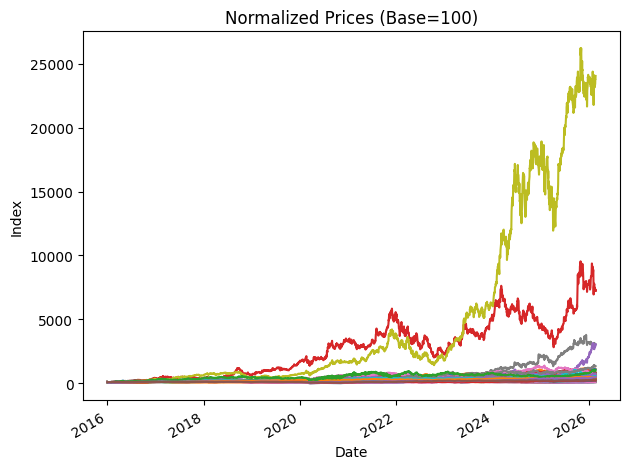

<Figure size 640x480 with 0 Axes>

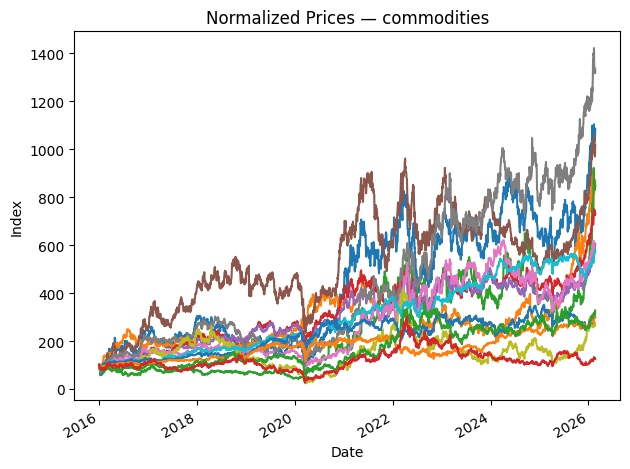

<Figure size 640x480 with 0 Axes>

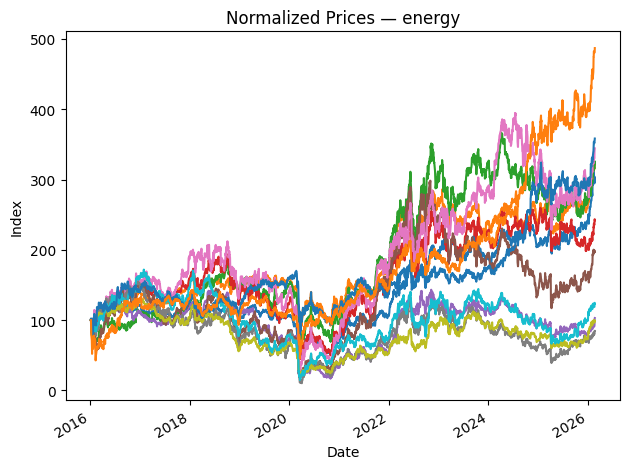

<Figure size 640x480 with 0 Axes>

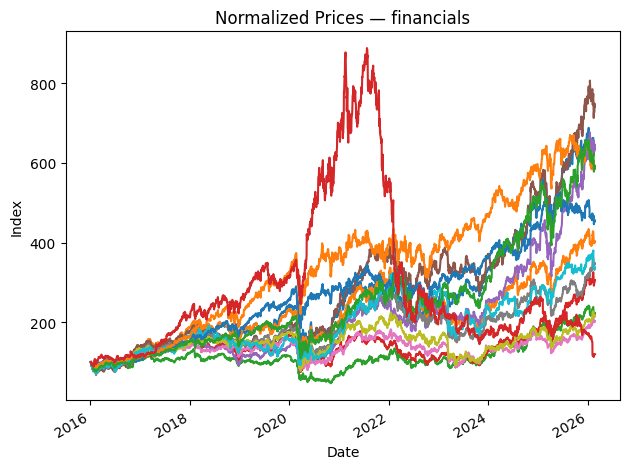

<Figure size 640x480 with 0 Axes>

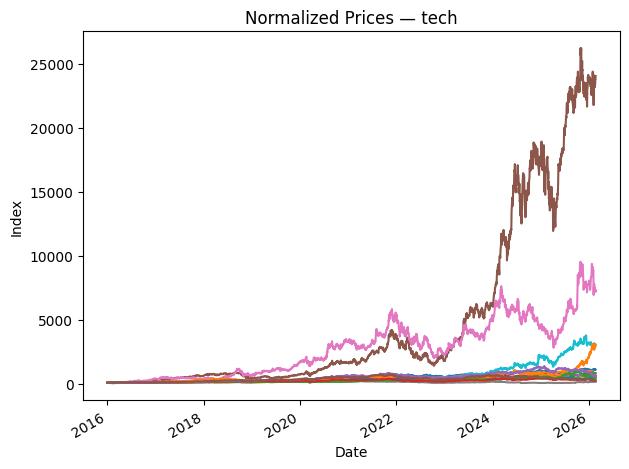

In [7]:
norm = prices / prices.iloc[0] * 100

plt.figure()
norm.plot(legend=False)
plt.title("Normalized Prices (Base=100)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_price_movements.png", dpi=200)
plt.show()

# Optional: per-bucket plots (cleaner)
for bucket in sorted(meta["bucket"].unique()):
    tickers = meta.loc[meta["bucket"] == bucket, "ticker"].tolist()
    sub = norm[tickers]
    plt.figure()
    sub.plot(legend=False)
    plt.title(f"Normalized Prices — {bucket}")
    plt.xlabel("Date")
    plt.ylabel("Index")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"eda_price_movements_{bucket}.png", dpi=200)
    plt.show()

In [8]:
ann_factor = 252

summary = pd.DataFrame({
    "mean_daily": rets.mean(),
    "std_daily": rets.std(),
    "skew": rets.skew(),
    "kurtosis": rets.kurtosis(),  # excess kurtosis
})

summary["mean_ann"] = summary["mean_daily"] * ann_factor
summary["vol_ann"] = summary["std_daily"] * np.sqrt(ann_factor)
summary["sharpe_ann"] = summary["mean_ann"] / summary["vol_ann"]

summary = summary.reset_index().rename(columns={"index": "ticker"})
summary = summary.merge(meta[["ticker","bucket","subcluster"]], on="ticker", how="left")
summary = summary.sort_values(["bucket","subcluster","ticker"])

summary.to_csv(STATS_DIR / "summary_statistics.csv", index=False)
summary.head(10)

,ticker,mean_daily,std_daily,skew,kurtosis,mean_ann,vol_ann,sharpe_ann,bucket,subcluster
0,AA,0.000398,0.034614,-0.191264,4.289890,0.100178,0.549476,0.182315,commodities,aluminum
6,APD,0.000432,0.016365,-0.851009,14.961735,0.108859,0.259788,0.419030,commodities,chemicals
17,ECL,0.000433,0.015757,-0.002531,19.110782,0.109209,0.250132,0.436608,commodities,chemicals
28,LIN,0.000692,0.014393,-0.060675,6.777765,0.174297,0.228486,0.762834,commodities,chemicals
12,CF,0.000457,0.025472,-0.309073,3.531347,0.115288,0.404352,0.285119,commodities,fertilizers
31,MOS,0.000090,0.028544,-0.722458,9.929156,0.022573,0.453124,0.049815,commodities,fertilizers
10,BHP,0.000708,0.020924,-0.318980,5.622484,0.178312,0.332164,0.536819,commodities,miners
20,FCX,0.000936,0.032884,-0.190270,5.757220,0.235947,0.522023,0.451985,commodities,miners
21,GOLD,0.000840,0.029292,0.360311,6.984669,0.211590,0.464996,0.455035,commodities,miners
35,NEM,0.000837,0.022726,-0.317509,4.972904,0.211038,0.360759,0.584983,commodities,miners


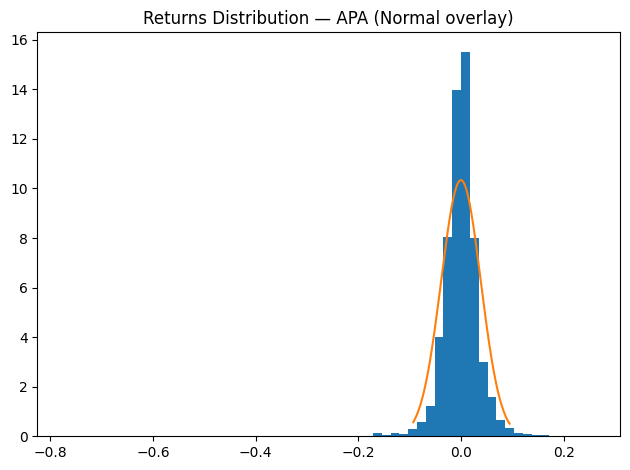

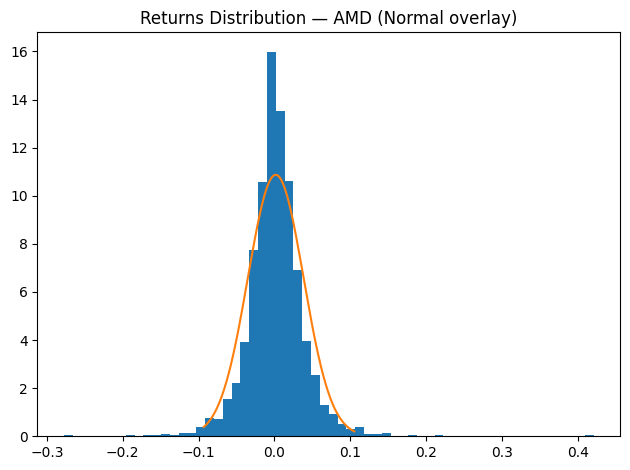

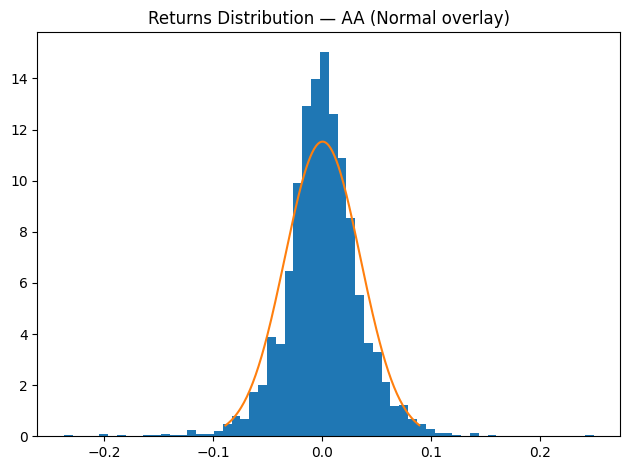

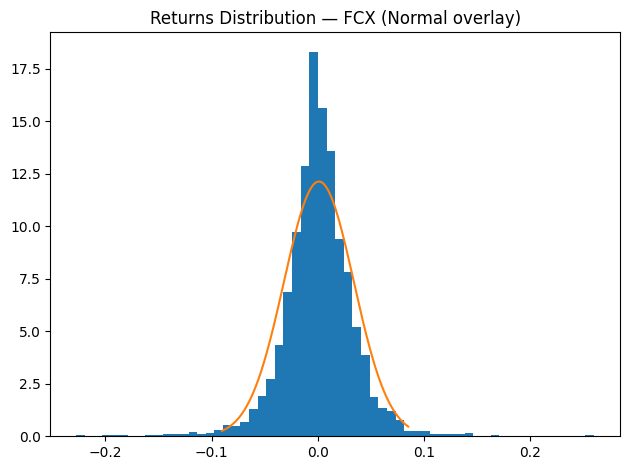

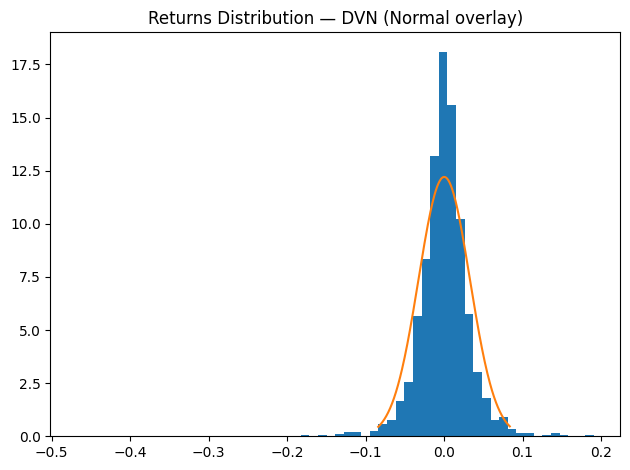

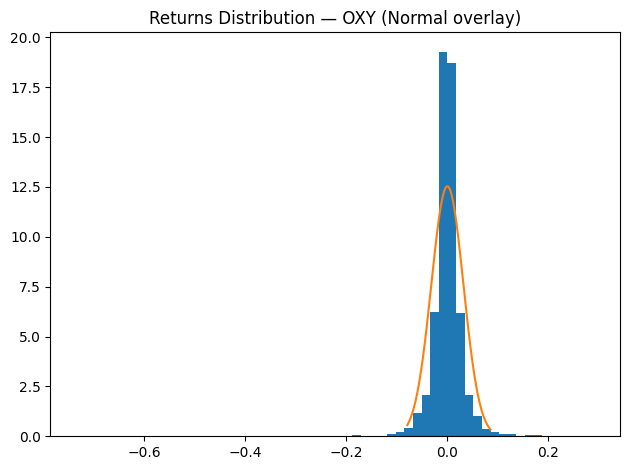

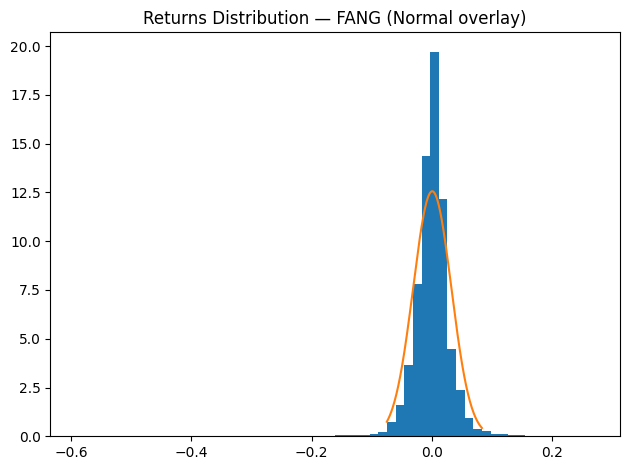

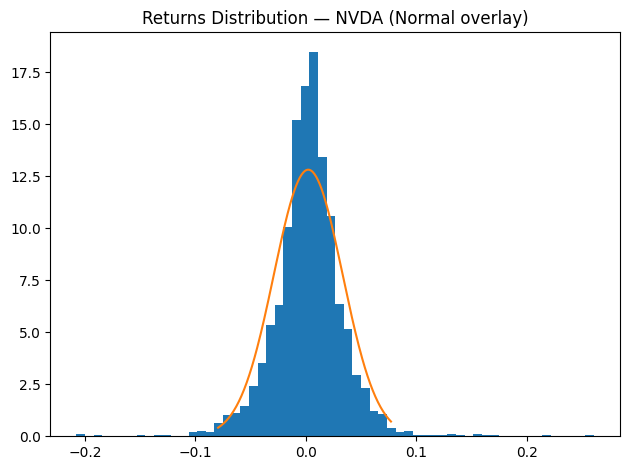

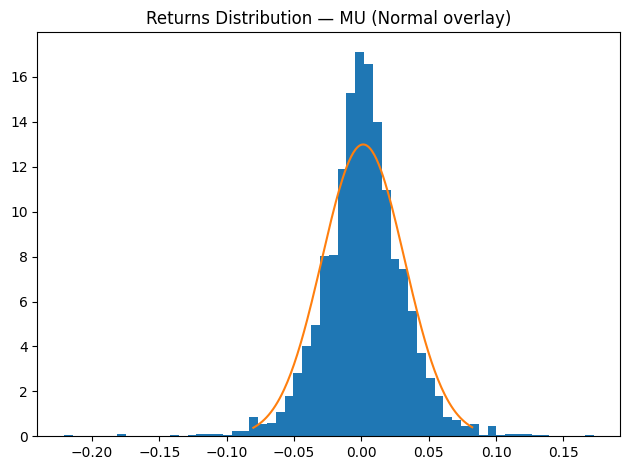

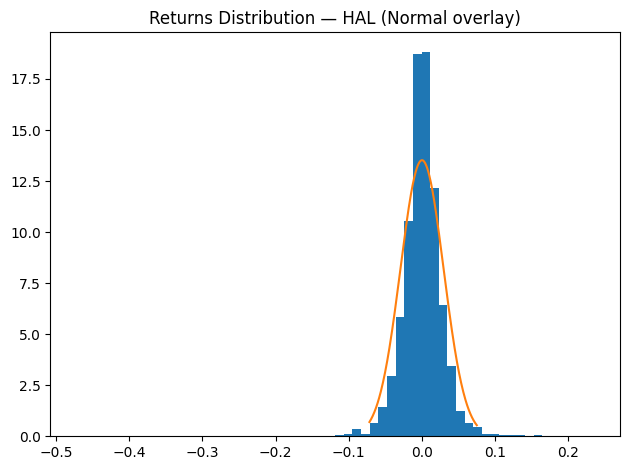

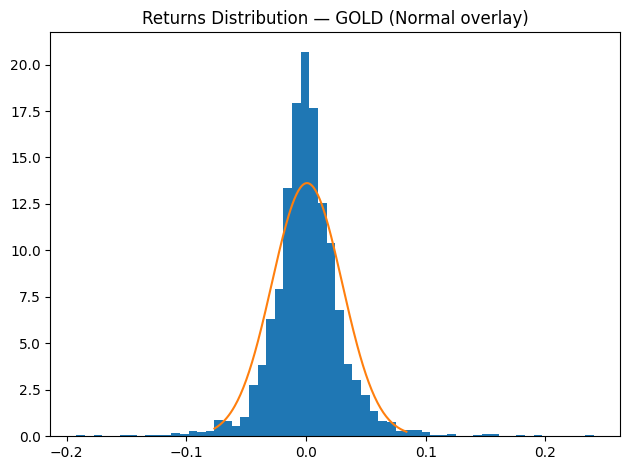

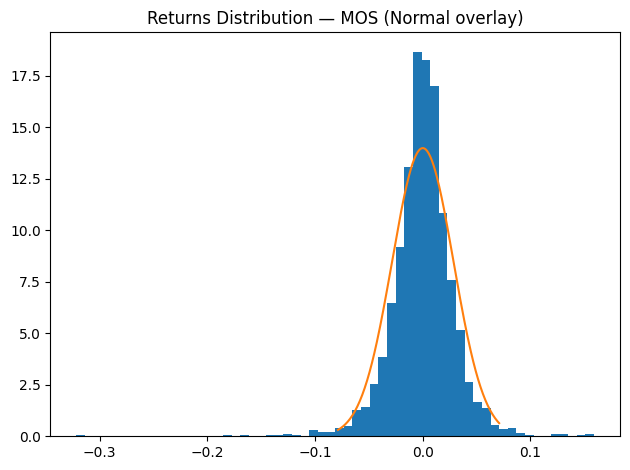

In [9]:
# sample a subset for plotting so it doesn't spam 56 plots
plot_tickers = summary.sort_values("vol_ann", ascending=False)["ticker"].head(12).tolist()

for t in plot_tickers:
    x = rets[t].dropna().values
    mu, sig = x.mean(), x.std()
    xx = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)
    pdf = stats.norm.pdf(xx, mu, sig)

    plt.figure()
    plt.hist(x, bins=60, density=True)
    plt.plot(xx, pdf)
    plt.title(f"Returns Distribution — {t} (Normal overlay)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"eda_returns_distribution_{t}.png", dpi=200)
    plt.show()

# One combined figure: all tickers hist grid is messy; keep individual + summary stats CSV

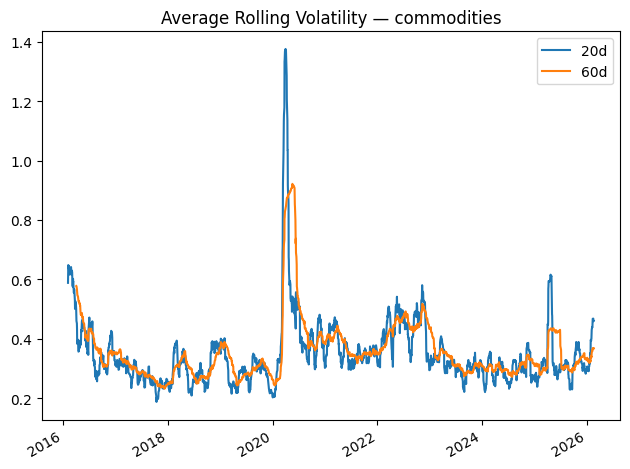

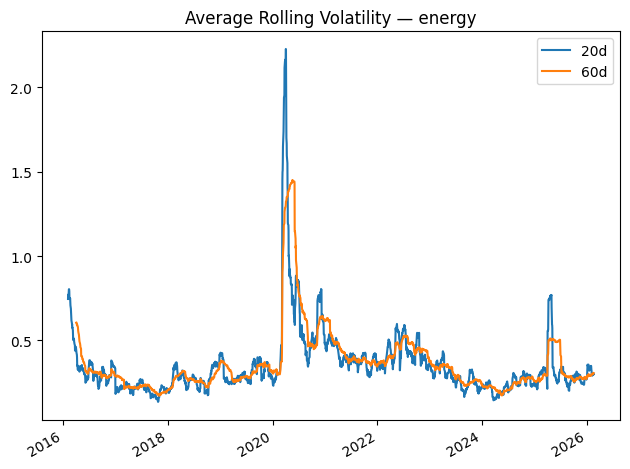

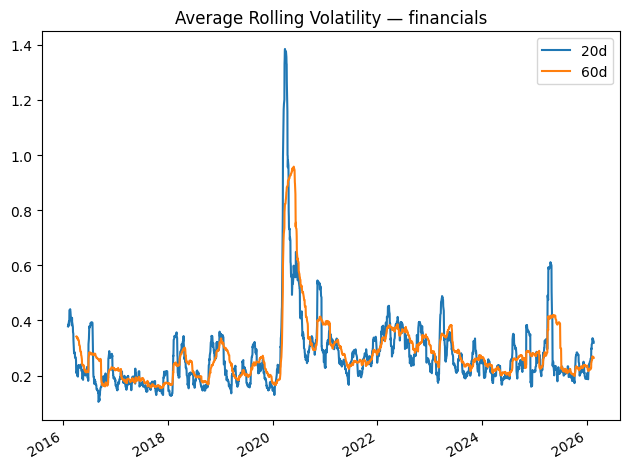

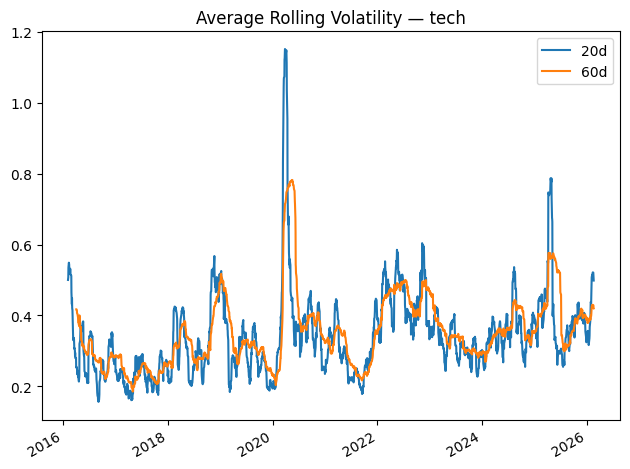

In [10]:
vol20 = rets.rolling(20).std() * np.sqrt(252)
vol60 = rets.rolling(60).std() * np.sqrt(252)

# Plot average vol by bucket
tmp = meta.set_index("ticker")

for bucket in sorted(meta["bucket"].unique()):
    tickers = meta.loc[meta["bucket"] == bucket, "ticker"].tolist()
    plt.figure()
    vol20[tickers].mean(axis=1).plot(label="20d")
    vol60[tickers].mean(axis=1).plot(label="60d")
    plt.title(f"Average Rolling Volatility — {bucket}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"eda_rolling_vol_{bucket}.png", dpi=200)
    plt.show()

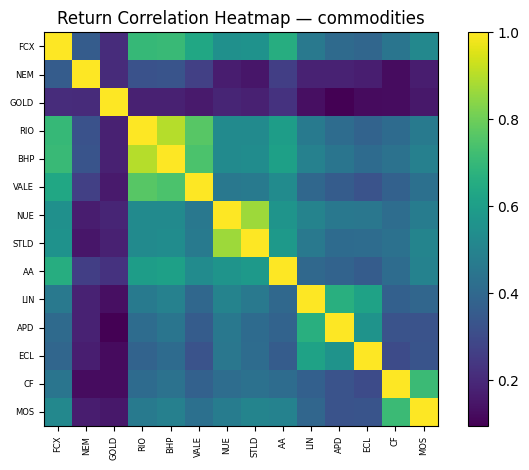

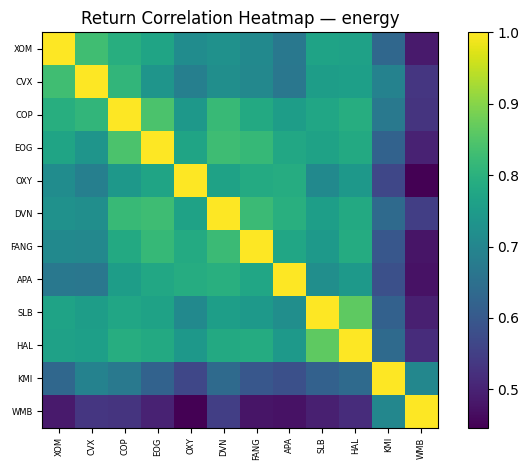

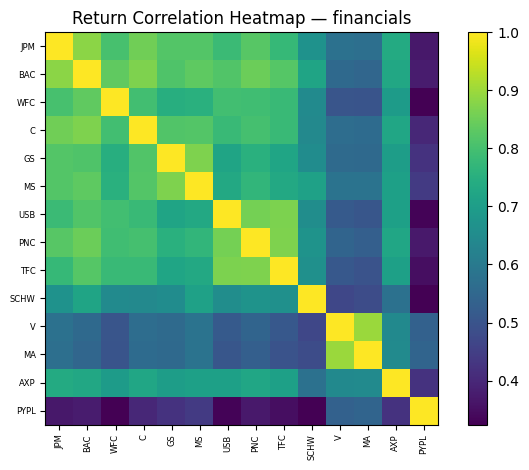

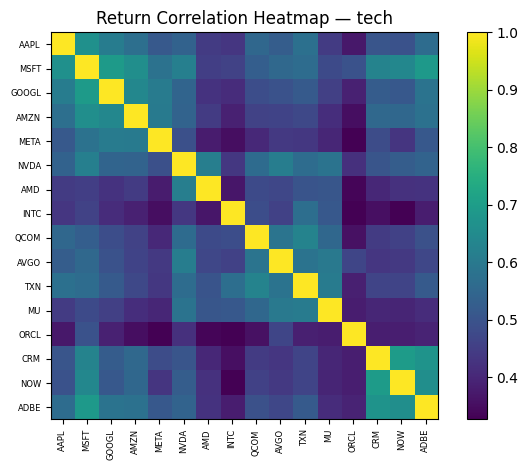

In [11]:
import matplotlib.pyplot as plt

for bucket in sorted(meta["bucket"].unique()):
    tickers = meta.loc[meta["bucket"] == bucket, "ticker"].tolist()
    corr = rets[tickers].corr()

    plt.figure()
    plt.imshow(corr.values)
    plt.title(f"Return Correlation Heatmap — {bucket}")
    plt.xticks(range(len(tickers)), tickers, rotation=90, fontsize=6)
    plt.yticks(range(len(tickers)), tickers, fontsize=6)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"eda_correlation_heatmap_{bucket}.png", dpi=200)
    plt.show()

    corr.to_csv(STATS_DIR / f"correlation_matrix_{bucket}.csv")

/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)


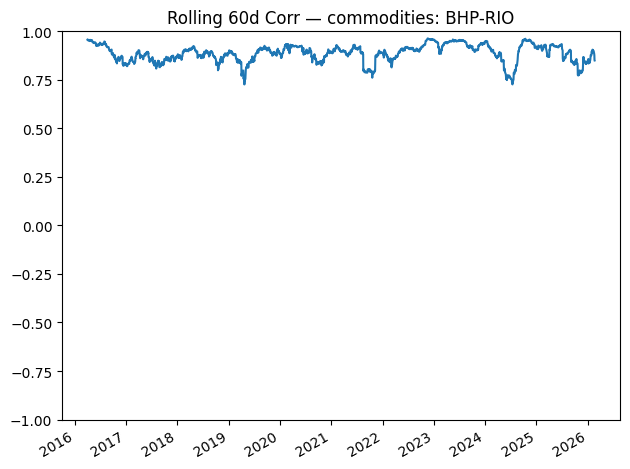

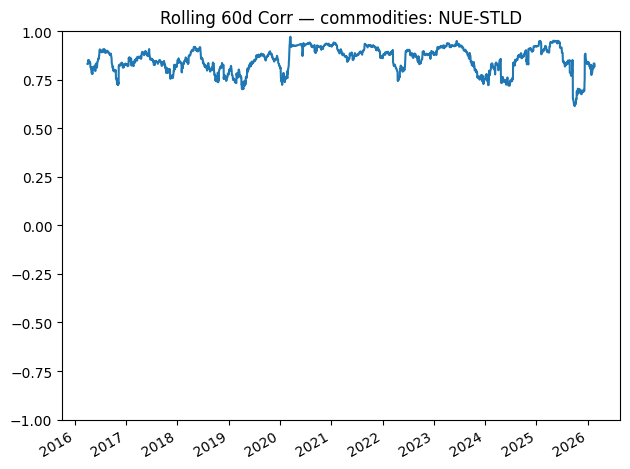

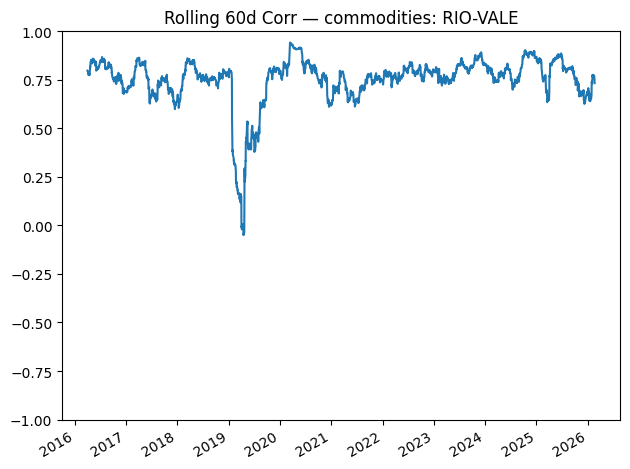

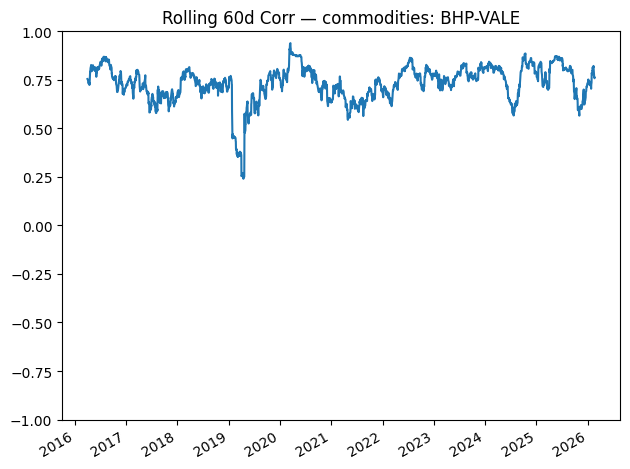

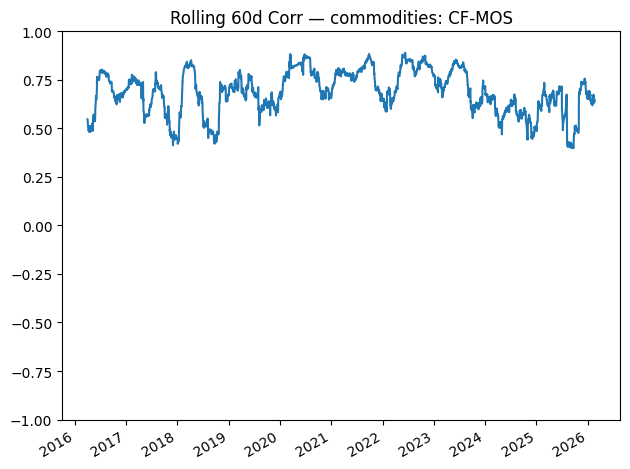

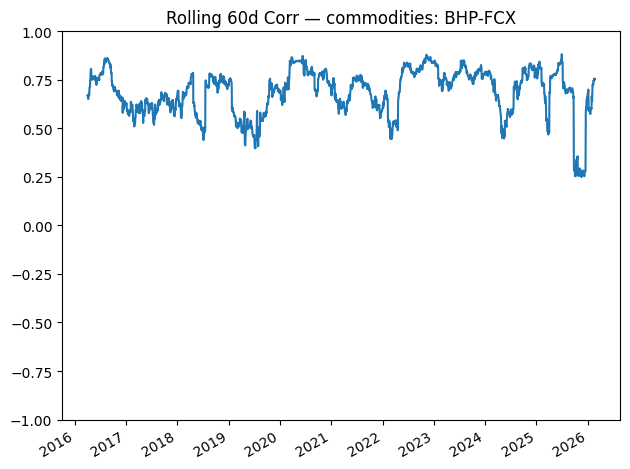

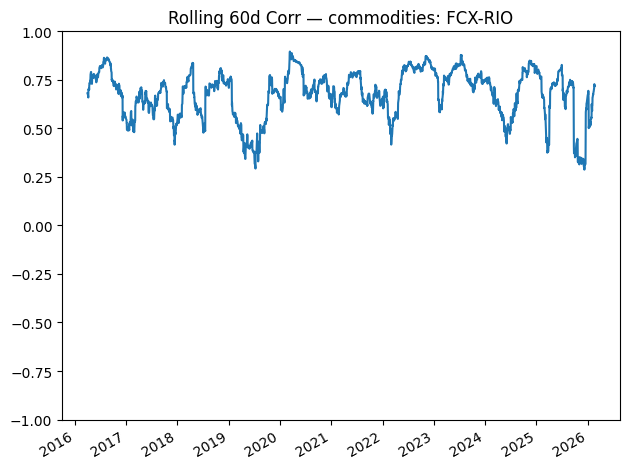

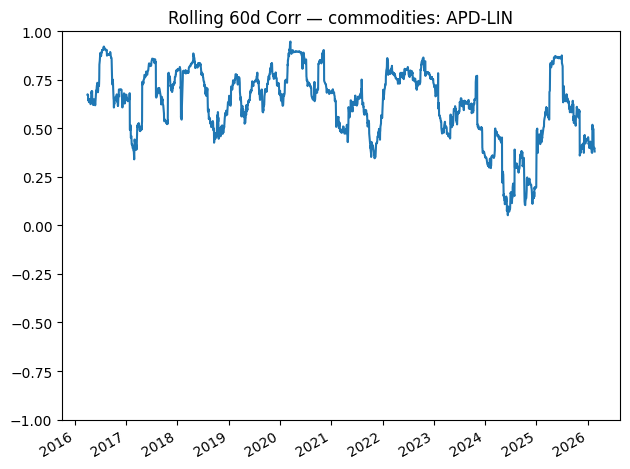

/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)


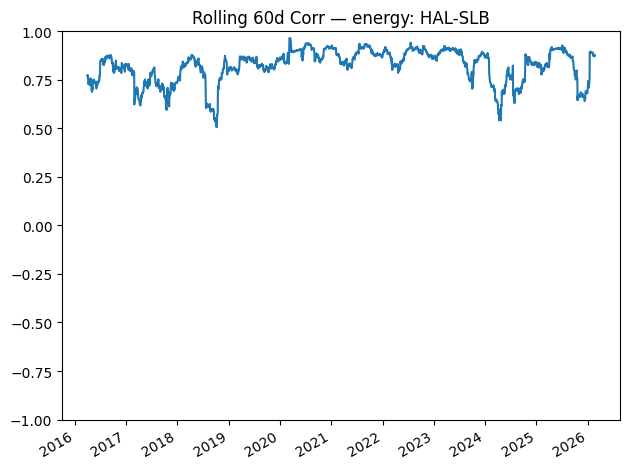

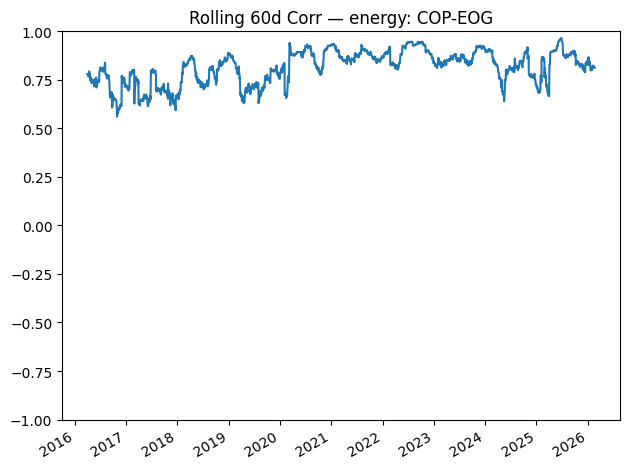

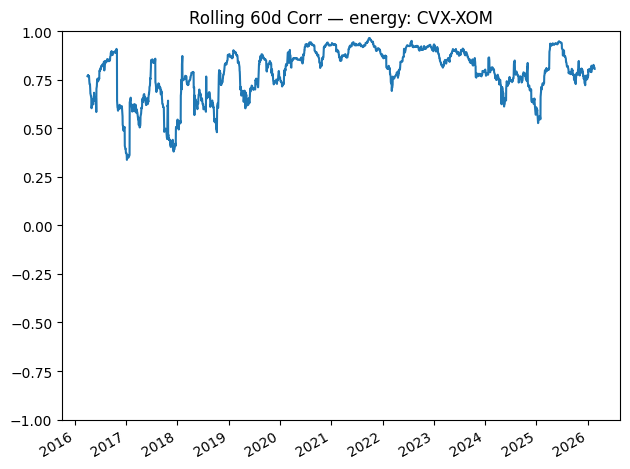

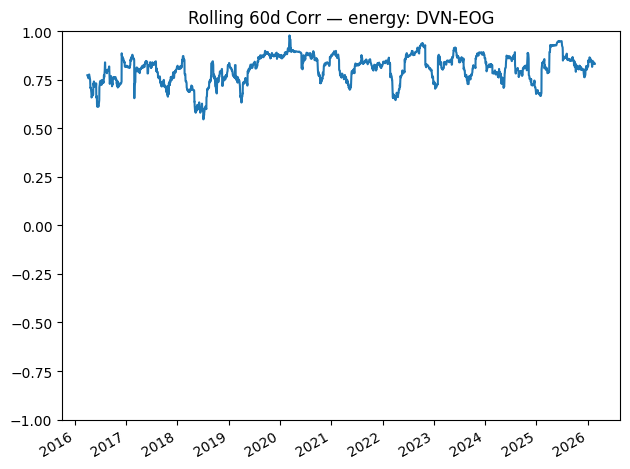

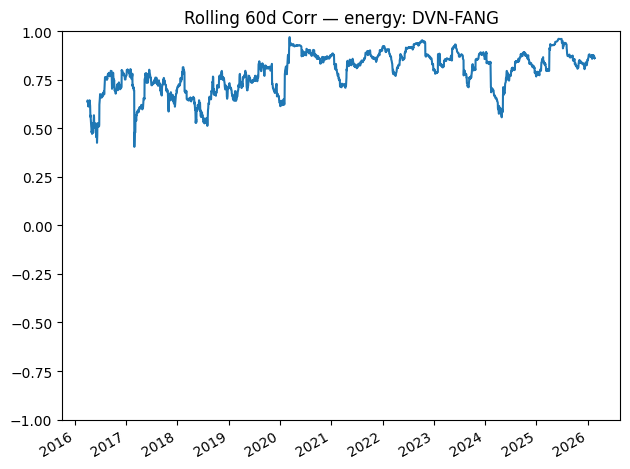

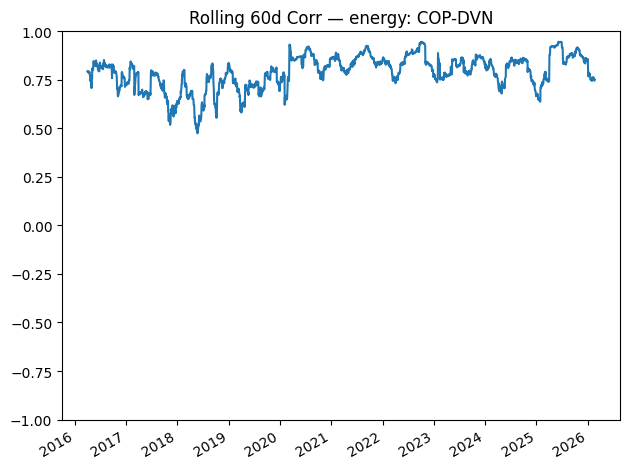

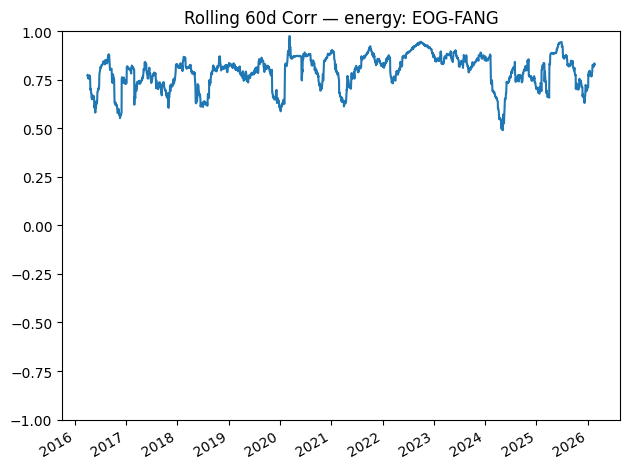

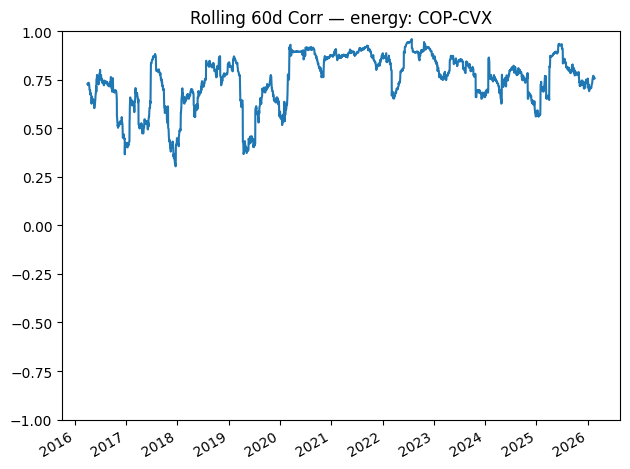

/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)


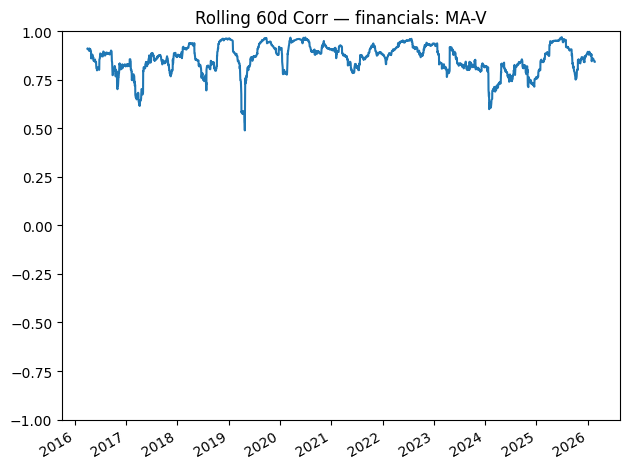

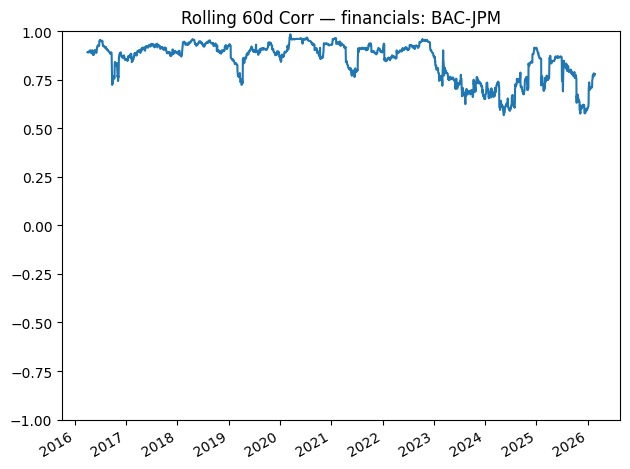

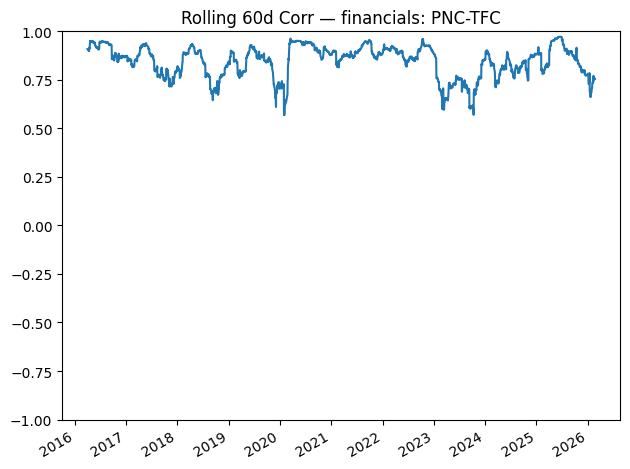

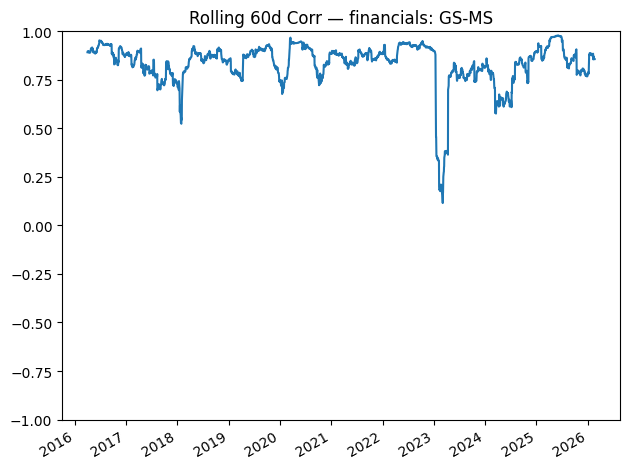

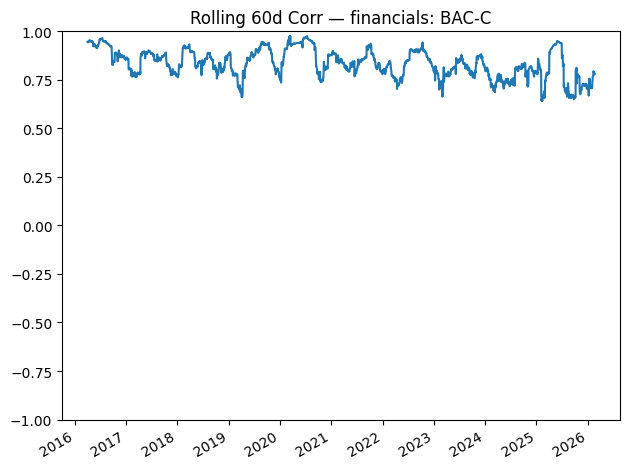

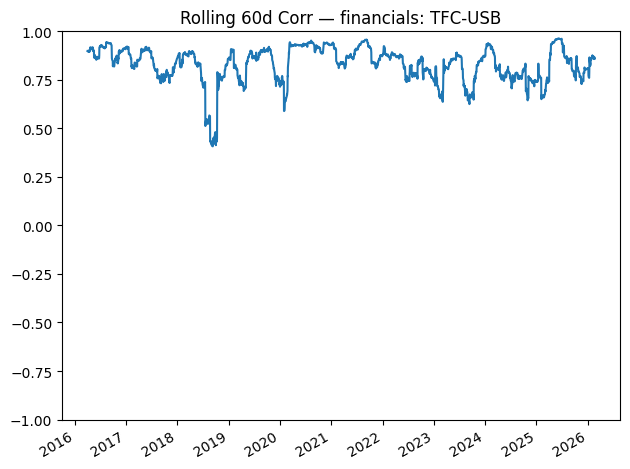

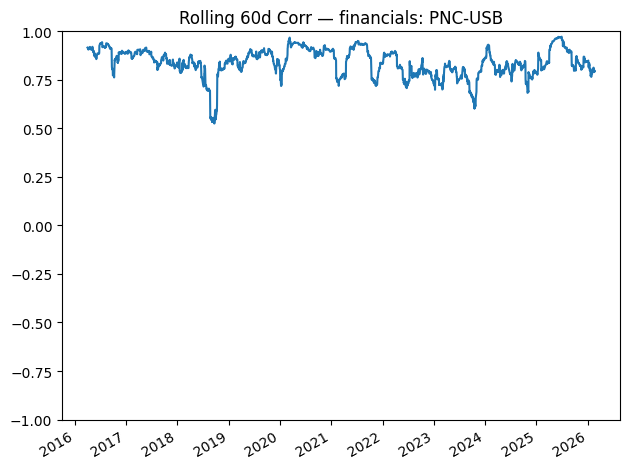

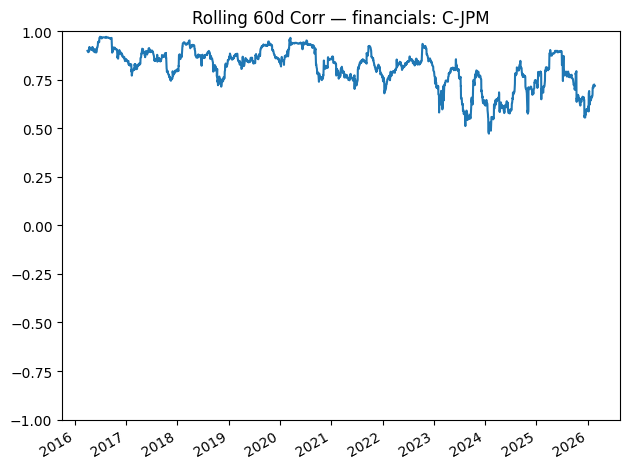

/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)


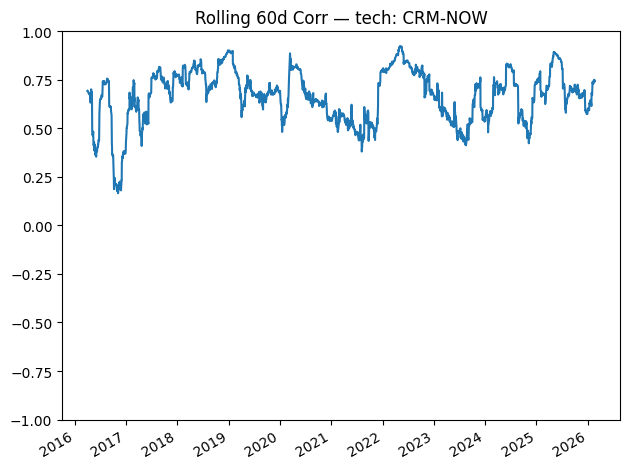

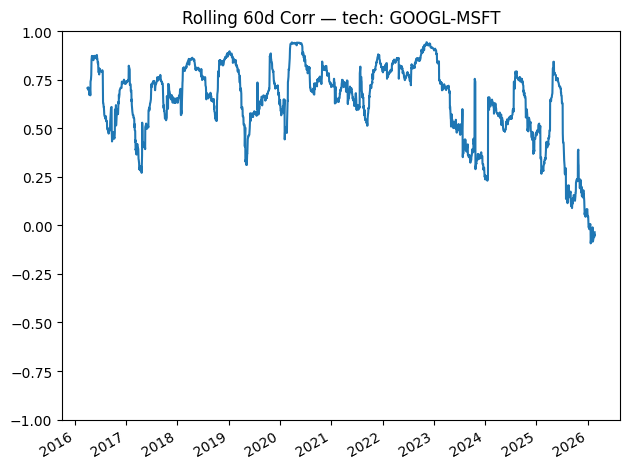

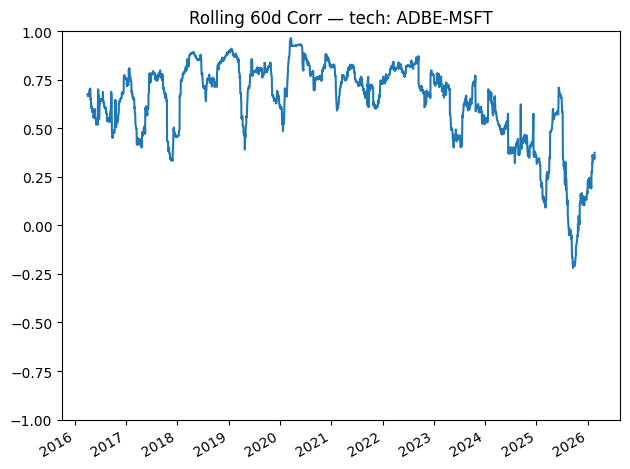

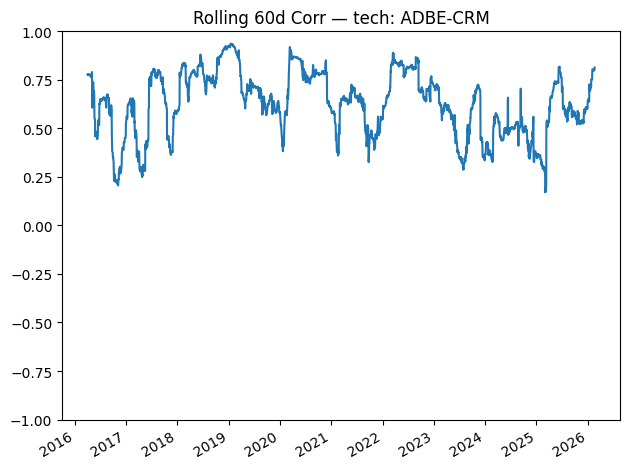

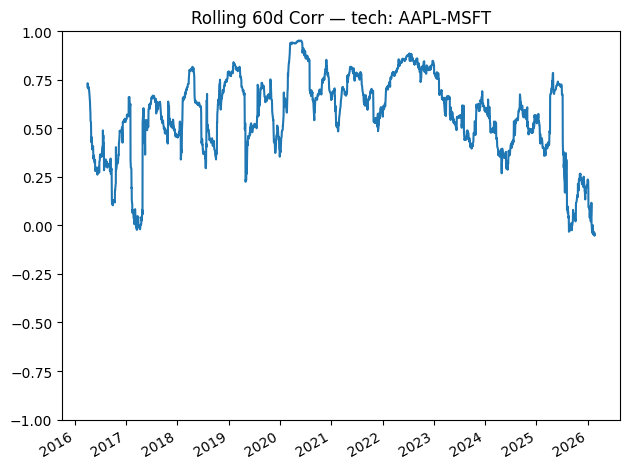

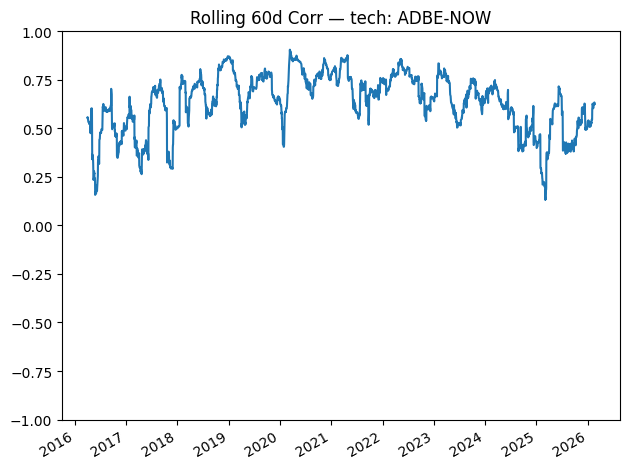

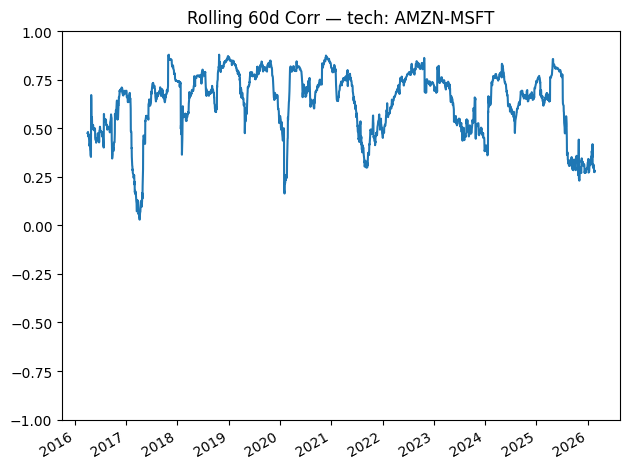

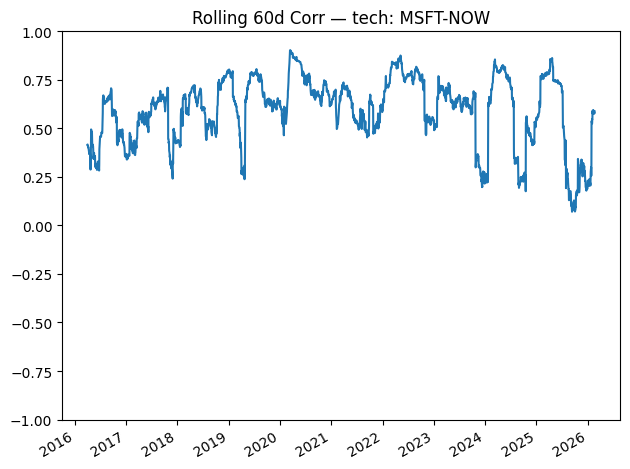

,a,b,corr,bucket
0,BHP,RIO,0.898105,commodities
1,NUE,STLD,0.866849,commodities
2,RIO,VALE,0.765738,commodities
3,BHP,VALE,0.743717,commodities
4,CF,MOS,0.711124,commodities
5,BHP,FCX,0.706842,commodities
6,FCX,RIO,0.700140,commodities
7,APD,LIN,0.664836,commodities
8,HAL,SLB,0.861763,energy
9,COP,EOG,0.843259,energy


In [13]:
def top_pairs_by_corr(corr_df: pd.DataFrame, topn: int = 10) -> pd.DataFrame:
    corr = corr_df.copy()

    # Avoid collisions caused by index/column names like "ticker"
    corr.index.name = None
    corr.columns.name = None

    # remove diagonal
    np.fill_diagonal(corr.values, np.nan)

    s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)
    pairs = s.reset_index()
    pairs.columns = ["a", "b", "corr"]  # force names

    # keep unique pairs only (a < b)
    pairs = pairs[pairs["a"] < pairs["b"]].sort_values("corr", ascending=False)

    return pairs.head(topn)

rolling_window = 60

all_top_pairs = []
for bucket in sorted(meta["bucket"].unique()):
    tickers = meta.loc[meta["bucket"] == bucket, "ticker"].tolist()
    corr = rets[tickers].corr()
    top_pairs = top_pairs_by_corr(corr, topn=8)
    top_pairs["bucket"] = bucket
    all_top_pairs.append(top_pairs)

    # plot rolling corr for these pairs
    for _, row in top_pairs.iterrows():
        a, b = row["a"], row["b"]
        rc = rets[a].rolling(rolling_window).corr(rets[b])

        plt.figure()
        rc.plot()
        plt.title(f"Rolling {rolling_window}d Corr — {bucket}: {a}-{b}")
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"eda_rolling_corr_{bucket}_{a}_{b}.png", dpi=200)
        plt.show()

pairs_out = pd.concat(all_top_pairs, ignore_index=True)
pairs_out.to_csv(STATS_DIR / "top_correlated_pairs_by_bucket.csv", index=False)
pairs_out.head(20)

In [14]:
def adf_test(series, maxlag=None):
    s = series.dropna()
    res = adfuller(s, maxlag=maxlag, autolag="AIC")
    return {
        "adf_stat": res[0],
        "p_value": res[1],
        "usedlag": res[2],
        "nobs": res[3],
        "crit_1%": res[4]["1%"],
        "crit_5%": res[4]["5%"],
        "crit_10%": res[4]["10%"],
    }

rows = []
for t in prices.columns:
    out_p = adf_test(logp[t])
    out_r = adf_test(rets[t])

    rows.append({
        "ticker": t,
        "bucket": meta.loc[meta["ticker"] == t, "bucket"].iloc[0],
        "subcluster": meta.loc[meta["ticker"] == t, "subcluster"].iloc[0],
        "series": "log_price",
        **out_p
    })
    rows.append({
        "ticker": t,
        "bucket": meta.loc[meta["ticker"] == t, "bucket"].iloc[0],
        "subcluster": meta.loc[meta["ticker"] == t, "subcluster"].iloc[0],
        "series": "return",
        **out_r
    })

adf_df = pd.DataFrame(rows)
adf_df.to_csv(STATS_DIR / "stationarity_tests.csv", index=False)

# quick sanity: percent rejecting unit root
print("Reject unit root (p<0.05) for log prices:", (adf_df.query("series=='log_price'")["p_value"] < 0.05).mean())
print("Reject unit root (p<0.05) for returns:", (adf_df.query("series=='return'")["p_value"] < 0.05).mean())

adf_df.head(10)

Reject unit root (p<0.05) for log prices: 0.017857142857142856
Reject unit root (p<0.05) for returns: 1.0


,ticker,bucket,subcluster,series,adf_stat,p_value,usedlag,nobs,crit_1%,crit_5%,crit_10%
0,AA,commodities,aluminum,log_price,-1.696851,4.327359e-01,0,2547,-3.432920,-2.862675,-2.567374
1,AA,commodities,aluminum,return,-34.693184,0.000000e+00,1,2545,-3.432922,-2.862676,-2.567375
2,AAPL,tech,mega,log_price,-1.149614,6.948866e-01,9,2538,-3.432929,-2.862679,-2.567377
3,AAPL,tech,mega,return,-16.363639,2.854641e-29,8,2538,-3.432929,-2.862679,-2.567377
4,ADBE,tech,software,log_price,-2.252842,1.876283e-01,9,2538,-3.432929,-2.862679,-2.567377
5,ADBE,tech,software,return,-16.667139,1.556170e-29,8,2538,-3.432929,-2.862679,-2.567377
6,AMD,tech,semis,log_price,-2.426086,1.345088e-01,3,2544,-3.432923,-2.862677,-2.567375
7,AMD,tech,semis,return,-30.272191,0.000000e+00,2,2544,-3.432923,-2.862677,-2.567375
8,AMZN,tech,mega,log_price,-1.717516,4.221112e-01,0,2547,-3.432920,-2.862675,-2.567374
9,AMZN,tech,mega,return,-51.686858,0.000000e+00,0,2546,-3.432921,-2.862676,-2.567375


In [15]:
candidates = []

for (bucket, subcluster), g in meta.groupby(["bucket","subcluster"]):
    tickers = g["ticker"].tolist()
    if len(tickers) < 2:
        continue
    corr = rets[tickers].corr()
    top_pairs = top_pairs_by_corr(corr, topn=min(25, len(tickers)*(len(tickers)-1)//2))
    top_pairs["bucket"] = bucket
    top_pairs["subcluster"] = subcluster
    candidates.append(top_pairs)

candidates = pd.concat(candidates, ignore_index=True)

# hard filter: keep corr >= 0.5 (tune later)
candidates = candidates[candidates["corr"] >= 0.5].sort_values("corr", ascending=False)

candidates.to_csv(STATS_DIR / "candidate_pairs_precointegration.csv", index=False)
candidates.head(30)

/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)
/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  s = corr.stack(dropna=True)  # Series with MultiIndex (row_ticker, col_ticker)
/tmp/ipython-input-339164044.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new imp

,a,b,corr,bucket,subcluster
63,MA,V,0.898860,financials,payments
4,BHP,RIO,0.898105,commodities,miners
38,BAC,JPM,0.883437,financials,banks
39,PNC,TFC,0.869094,financials,banks
40,GS,MS,0.868205,financials,banks
41,BAC,C,0.868025,financials,banks
42,TFC,USB,0.866889,financials,banks
19,NUE,STLD,0.866849,commodities,steel
37,HAL,SLB,0.861763,energy,services
43,PNC,USB,0.858095,financials,banks
